
Lab: `tensoflow` 範例
================

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

## Linear Regression

In [2]:
# define a function to generate x and y
def generate_linear_reg_data(
    n_sample, weight, intercept = 0, sd_residual = 1,
    dtype = tf.float64, seed = None):
    weight = tf.constant(weight, dtype = dtype)
    weight = tf.reshape(weight, shape = (-1, 1))
    n_feature = weight.shape[0]
    x = tf.random.normal(shape = (n_sample, n_feature),
                         seed = seed, dtype = dtype)
    e = tf.random.normal(shape = (n_sample, 1),
                         seed = seed, dtype = dtype)
    y = intercept + x @ weight + e
    return x, y

# run generate_data
n_sample = 10000
weight_true = [-1, 2, 0]
dtype = tf.float64

x, y = generate_linear_reg_data(
    n_sample = n_sample, weight = weight_true,
    intercept = 0, sd_residual = 1,
    dtype = dtype, seed = 48)

In [3]:
# start optimization
n_feature = len(weight_true)
learning_rate = .1
epochs = 500
tol = 10**(-4)

optimizer = tf.optimizers.SGD(learning_rate = learning_rate)

intercept = tf.Variable(tf.zeros((), dtype = dtype), 
                        name = "intercept")
weight = tf.Variable(tf.zeros((n_feature, 1), dtype = dtype), 
                     name = "weight")

for epoch in tf.range(epochs):
    with tf.GradientTape() as tape:
        y_hat = intercept + x @ weight
        loss_value = tf.reduce_mean((y - y_hat)**2)
    gradients = tape.gradient(loss_value, [intercept, weight])
    optimizer.apply_gradients(zip(gradients, [intercept, weight]))
    #print(weight)
    if (tf.reduce_max(
            [tf.reduce_mean(
                tf.math.abs(x)) for x in gradients]).numpy()) < tol:
        print("{n} Optimizer Converges After {i} Iterations".format(
            n=optimizer.__class__.__name__, i=epoch))
        break

print("intercept", intercept.numpy())
print("weight", weight.numpy())

SGD Optimizer Converges After 45 Iterations
intercept -0.012025053092215557
weight [[-0.99697044]
 [ 1.99617999]
 [ 0.02433336]]


## Logistic Regression

In [4]:
# define a function to generate x and y
def generate_logistic_reg_data(
    n_sample, weight, intercept = 0, 
    dtype = tf.float64, seed = None):
    weight = tf.constant(weight, dtype = dtype)
    weight = tf.reshape(weight, shape = (-1, 1))
    n_feature = weight.shape[0]
    x = tf.random.normal(shape = (n_sample, n_feature),
                         seed = seed, dtype = dtype)
    logits = intercept + x @ weight
    y = tfd.Bernoulli(logits=logits, dtype=dtype).sample()
    return x, y

# run generate_data
n_sample = 10000
weight_true = [-1, 2, 0]
dtype = tf.float64

x, y = generate_logistic_reg_data(
    n_sample = n_sample, 
    weight = weight_true,intercept = 0, 
    dtype = dtype, seed = 48)

In [5]:
# define a tf.Module to collect parameters
class LinearModel(tf.Module):
  def __init__(self, n_feature, dtype = tf.float64):
    super().__init__()
    self.weight = tf.Variable(tf.zeros((n_feature, 1), 
                                       dtype = dtype), 
                              name = "weight")
    self.intercept = tf.Variable(tf.zeros((), dtype = dtype), 
                                 name = "intercept")
  def __call__(self, x):
    return self.intercept + x @ self.weight

In [6]:
n_feature = len(weight_true)
learning_rate = .5
epochs = 500
tol = 10**(-4)

linear_model = LinearModel(n_feature, dtype)
optimizer = tf.optimizers.SGD(learning_rate = learning_rate)

for epoch in tf.range(epochs):
    with tf.GradientTape() as tape:
        logits = linear_model(x)
        loss_value = - tf.reduce_mean(
            tfd.Bernoulli(logits=logits).log_prob(y))
    gradients = tape.gradient(
        loss_value, linear_model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, linear_model.trainable_variables))
    if (tf.reduce_max(
            [tf.reduce_mean(
                tf.math.abs(x)) for x in gradients]).numpy()) < tol:
        print("{n} Optimizer Converges After {i} Iterations".format(
            n=optimizer.__class__.__name__, i=epoch))
        break

print("intercept", linear_model.intercept.numpy())
print("weight", linear_model.weight.numpy())

SGD Optimizer Converges After 226 Iterations
intercept 0.018624852750212684
weight [[-1.01441119]
 [ 2.07139214]
 [-0.02560208]]


## Factor Analysis

In [7]:
def generate_fa_data(n_sample, n_factor, n_item, 
                     ld, psi = None, rho = None, 
                     dtype = tf.float64):
    if (n_item % n_factor) != 0:
        n_item = n_factor * (n_item // n_factor)
    loading = np.zeros((n_item, n_factor))
    item_per_factor = (n_item // n_factor)
    for i in range(n_factor):
        for j in range(i * item_per_factor,
                       (i + 1) * item_per_factor):
            loading[j, i] = ld
    loading = tf.constant(loading, dtype = dtype)
    if rho is None:
        cor = tf.eye(n_factor, dtype = dtype)
    else:
        unit = tf.ones((n_factor, 1), dtype = dtype)
        identity = tf.eye(n_factor, dtype = dtype)
        cor = rho * (unit @ tf.transpose(unit)) + (1 - rho) * identity
    if psi is None:
        uniqueness = 1 - tf.linalg.diag_part(loading @ cor @ tf.transpose(loading))
    else:
        uniqueness = psi * tf.ones((n_item, ), dtype = dtype)
    
    mean = tf.zeros(n_item, dtype = dtype)
    cov = loading @ cor @ tf.transpose(loading) + tf.linalg.diag(uniqueness)
    dist_x = tfd.MultivariateNormalTriL(
        loc = mean, scale_tril = tf.linalg.cholesky(cov))
    x = dist_x.sample(n_sample)
    return x

n_sample = 10000
n_factor = 4
n_item = 12
ld = .7
dtype = tf.float64

x = generate_fa_data(n_sample, n_factor, 
                     n_item, ld,
                     dtype = dtype)
sample_mean = tf.reduce_mean(x, axis = 0)
sample_cov = tf.transpose(x - sample_mean) @ (x - sample_mean) / n_sample

In [8]:
sample_mean

<tf.Tensor: shape=(12,), dtype=float64, numpy=
array([-0.00297178,  0.0023064 , -0.00543589,  0.01030335,  0.01620562,
        0.00354845,  0.0173241 ,  0.01119512,  0.00894522, -0.00163948,
        0.01154066, -0.00952854])>

In [9]:
# define a tf.Module to coollect parameters
class FactorModel(tf.Module):
  def __init__(self, n_item, n_factor, 
               dtype = tf.float64):
    super().__init__()
    self.intercept = tf.Variable(
        tf.zeros(n_item, dtype = dtype), name = "intercept")
    self.loading = tf.Variable(
        tf.random.uniform((n_item, n_factor), dtype = dtype), 
        name = "loading")
    self.uniqueness = tf.Variable(
        tf.fill(n_item, value = tf.constant(.2, dtype = dtype)), 
        name = "uniqueness")
  def __call__(self):
      model_mean = self.intercept
      model_cov = self.loading @ tf.transpose(self.loading) + tf.linalg.diag(self.uniqueness)
      return model_mean, model_cov

In [10]:
learning_rate = .5
epochs = 500
tol = 10**(-4)

factor_model = FactorModel(n_item, n_factor, dtype)
optimizer = tf.optimizers.SGD(learning_rate = learning_rate)

for epoch in tf.range(epochs):
    with tf.GradientTape() as tape:
        model_mean, model_cov = factor_model()
        mvn = tfd.MultivariateNormalTriL(
            loc = model_mean, 
            scale_tril = tf.linalg.cholesky(model_cov))
        loss_value = - tf.reduce_mean(mvn.log_prob(x))
    gradients = tape.gradient(
        loss_value, factor_model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, factor_model.trainable_variables))
    if (tf.reduce_max(
            [tf.reduce_mean(
                tf.math.abs(x)) for x in gradients]).numpy()) < tol:
        print("{n} Optimizer Converges After {i} Iterations".format(
            n=optimizer.__class__.__name__, i=epoch))
        break

print("intercept", factor_model.intercept.numpy())
print("loading", factor_model.loading.numpy())
print("uniqueness", factor_model.uniqueness.numpy())

SGD Optimizer Converges After 94 Iterations
intercept [-0.00297178  0.0023064  -0.00543589  0.01030335  0.01620562  0.00354845
  0.0173241   0.01119512  0.00894522 -0.00163948  0.01154066 -0.00952854]
loading [[ 0.32201697  0.01642084 -0.04100319  0.63066625]
 [ 0.32674537  0.017146   -0.02945871  0.59252605]
 [ 0.31397258  0.01467024 -0.02726598  0.60138549]
 [-0.35925704 -0.16868686  0.54328278  0.23228625]
 [-0.36713426 -0.14299242  0.53827701  0.23144005]
 [-0.36943135 -0.15992695  0.55381386  0.21350927]
 [ 0.49919328 -0.01116984  0.41326406 -0.24805683]
 [ 0.50933655 -0.01500938  0.42080456 -0.26146489]
 [ 0.48115747 -0.01353824  0.4401694  -0.257501  ]
 [-0.07177533  0.68385012  0.12889856  0.04274879]
 [-0.0726081   0.67029127  0.12940358  0.03346163]
 [-0.06331207  0.69502703  0.13793051  0.04287903]]
uniqueness [0.49196496 0.51461259 0.52890638 0.51286385 0.51396283 0.51203993
 0.52058576 0.50785139 0.51175418 0.505354   0.54437636 0.51580434]


## Two-Parameter Logistic Model

In [11]:
def generate_2pl_data(n_sample, n_factor, n_item, 
                      alpha, beta, rho, 
                      dtype = tf.float64):
    if (n_item % n_factor) != 0:
        n_item = n_factor * (n_item // n_factor)
    item_per_factor = (n_item // n_factor)
    intercept = tf.fill((n_item,), value = tf.constant(alpha, dtype = dtype))
    loading = np.zeros((n_item, n_factor))
    for i in range(n_factor):
        for j in range(i * item_per_factor,
                       (i + 1) * item_per_factor):
            loading[j, i] = ld
    loading = tf.constant(loading, dtype = dtype)
    if rho is None:
        cor = tf.eye(n_factor, dtype = dtype)
    else:
        unit = tf.ones((n_factor, 1), dtype = dtype)
        identity = tf.eye(n_factor, dtype = dtype)
        cor = rho * (unit @ tf.transpose(unit)) + (1 - rho) * identity
    dist_eta = tfd.MultivariateNormalTriL(
        loc = tf.zeros(n_factor, dtype = dtype), scale_tril = tf.linalg.cholesky(cor))
    eta = dist_eta.sample(n_sample)
    logits = intercept + eta @ tf.transpose(loading)
    x = tfd.Bernoulli(logits=logits, dtype=dtype).sample()
    return x

In [12]:
n_sample = 10000
n_factor = 5
n_item = 25
alpha = .2
beta = .7 
rho = 0
dtype = tf.float64
x = generate_2pl_data(n_sample, n_factor, n_item, 
                      alpha, beta, rho, 
                      dtype = dtype)

In [13]:
class TwoPLModel(tf.Module):
    def __init__(self, n_item, n_factor, 
                 dtype = tf.float64):
        super().__init__()
        self.dtype = dtype
        self.intercept = tf.Variable(
            tf.zeros(n_item, dtype = self.dtype), name = "intercept")
        self.loading = tf.Variable(
            tf.random.uniform((n_item, n_factor), dtype = self.dtype), 
            name = "loading")
    def __call__(self, x):
        n_sample = len(x)
        joint_prob = tfd.JointDistributionSequential([
            tfd.Independent(
                tfd.Normal(
                    loc = tf.zeros((n_sample, n_factor), dtype=self.dtype),
                    scale = 1.0), 
                reinterpreted_batch_ndims=1),
            lambda eta: tfd.Independent(
                tfd.Bernoulli(
                    logits= self.intercept + eta @ tf.transpose(self.loading), 
                    dtype=self.dtype), 
                reinterpreted_batch_ndims=1)])             
        joint_prob._to_track=self
        return joint_prob

In [14]:
two_pl_model = TwoPLModel(n_item, n_factor)
joint_prob = two_pl_model(x)

def target_log_prob_fn(*eta):
    return joint_prob.log_prob(eta + (x,))

hmc=tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn = target_log_prob_fn,
    step_size = .015,
    num_leapfrog_steps=3)
current_state = joint_prob.sample()[:-1]
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False,
             experimental_compile=True)
def one_e_step(current_state, kernel_results):
    next_state, next_kernel_results = hmc.one_step(
        current_state=current_state,
        previous_kernel_results=kernel_results)
    return next_state, next_kernel_results

optimizer=tf.optimizers.RMSprop(learning_rate=.01)

@tf.function(autograph=False, 
             experimental_compile=True)
def one_m_step(current_state):
    with tf.GradientTape() as tape:
        loss_value = -tf.reduce_mean(
            target_log_prob_fn(*current_state))
    gradients = tape.gradient(loss_value, two_pl_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, two_pl_model.trainable_variables))
    return loss_value

In [15]:
import time
num_warmup_start = 1
num_warmup_iter = 1
num_iters = 1
num_accepted = 0
loss_history = np.zeros([num_iters])
tStart = time.time()
# Run warm-up stage.
for t in range(num_warmup_start):
    current_state, kernel_results = one_e_step(
        current_state, kernel_results)
    num_accepted += kernel_results.is_accepted.numpy().prod()
    if t % 500 == 0:
        print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
            t, num_accepted / (t + 1)))
num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
    for _ in range(num_warmup_iter):
        current_state, kernel_results = one_e_step(current_state, kernel_results)
    loss_value = one_m_step(current_state)
    num_accepted += kernel_results.is_accepted.numpy().prod()
    loss_history[t] = loss_value.numpy()
    if t % 50 == 0:
        print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
            t, num_accepted / (t + 1), loss_history[t]))
tEnd = time.time()

Warm-Up Iteration:   0 Acceptance Rate: 0.000


Iteration:    0 Acceptance Rate: 1.000 Loss: 28.959


In [16]:
print(tEnd - tStart)
print(np.around(two_pl_model.trainable_variables[0].numpy(), decimals=2))
print(np.around(two_pl_model.trainable_variables[1].numpy(), decimals=2))

2.3993680477142334
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
[[ 0.88  0.92  0.64  0.26  0.06]
 [ 0.1   0.46  0.04  0.45  0.7 ]
 [ 0.15  0.53  0.61  0.22  0.18]
 [ 0.01  0.33  0.41  0.74  0.78]
 [ 0.64  0.68  0.04  0.21  0.14]
 [-0.01 -0.    0.38  0.68  0.18]
 [ 0.79  0.65  0.72  0.31  0.39]
 [ 0.5   0.32  0.61  0.54  0.84]
 [ 0.78  0.19  0.02  0.53  0.64]
 [ 0.72  0.58  0.49  0.96  0.28]
 [ 0.81  0.16  0.62  0.61  0.95]
 [ 0.33  0.61  0.67  0.89  0.24]
 [ 0.73  0.16  0.18  0.64 -0.02]
 [ 0.74  0.84  0.09  0.96  0.91]
 [ 0.65  0.04  0.32  0.95  0.74]
 [ 0.58  0.25  0.48  0.81  0.46]
 [ 0.54  0.65  0.92 -0.   -0.01]
 [ 0.38  0.47  0.89  0.26  0.2 ]
 [ 0.76  0.82  0.24  0.68  0.24]
 [ 0.02  0.78  0.87  0.39  0.06]
 [ 0.63  0.05  0.42  0.36  0.3 ]
 [ 0.84  0.59  0.11  0.03  0.45]
 [ 0.84  0.57  0.96  0.23  0.04]
 [ 0.15  0.21  0.37  0.89  0.92]
 [ 0.92  0.74  0.35  0.55  0.5 ]]


[Text(0, 0.5, 'Loss Value'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Gradient Descent History')]

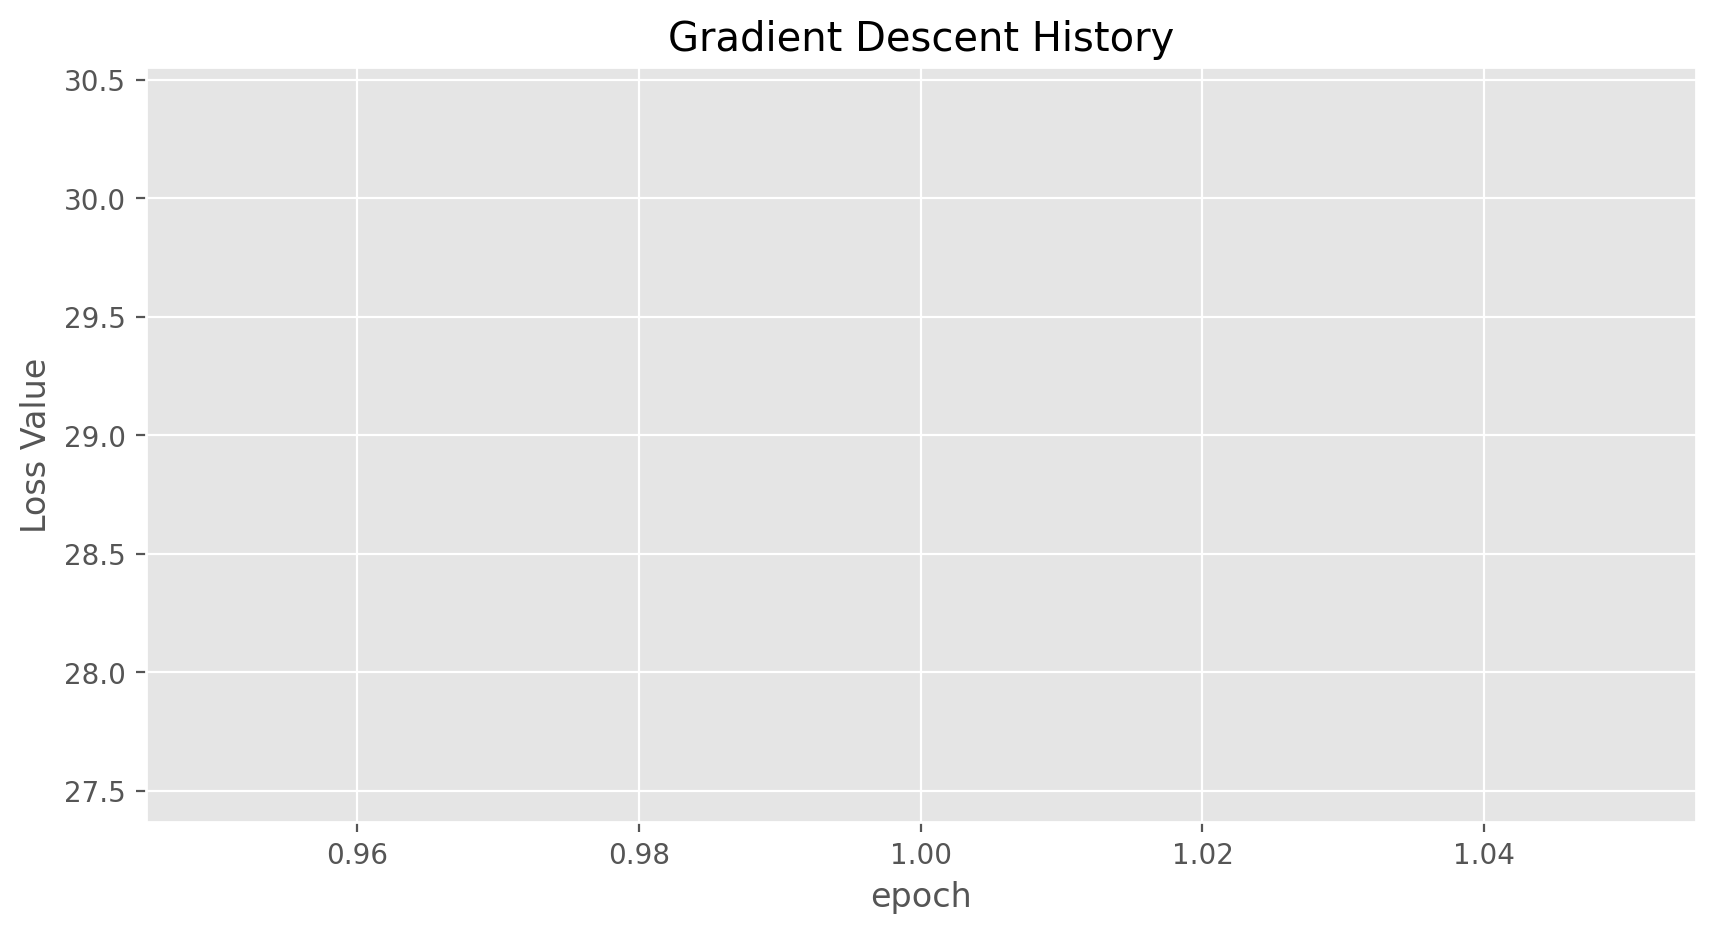

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = plt.axes()
ax.plot(list(range(1, len(loss_history) + 1, 1)),loss_history )
ax.set(xlabel='epoch', ylabel='Loss Value',
       title='Gradient Descent History')

## Grade Response Model

In [18]:
def create_cd(n_category, dtype):
    c1 = tf.linalg.diag(
        tf.fill([n_category - 1],
                tf.constant([1], dtype = dtype)),
        k = 0, num_rows= n_category - 1, num_cols= n_category)
    c2 = tf.linalg.diag(
        tf.fill([n_category - 1],
            tf.constant([1], dtype = dtype)),
        k = 1, num_rows= n_category - 1, num_cols= n_category)
    c = c1 - c2
    d = tf.squeeze(tf.linalg.diag(
        tf.constant([1], dtype = dtype),
        k = n_category - 1, num_rows= 1, num_cols= n_category))
    return c, d

def grm_irf(eta, intercept, loading, c, d):
    tau = tf.expand_dims(eta @ tf.transpose(loading), axis = 2) + intercept
    probs = tf.math.sigmoid(tau) @ c + d
    return probs

In [19]:
def generate_grm_data(n_sample, n_factor, n_item,
                      nu, ld, rho,
                      dtype = tf.float64):
    if (n_item % n_factor) != 0:
        n_item = n_factor * (n_item // n_factor)
    item_per_factor = (n_item // n_factor)
    n_category = len(nu) + 1
    intercept = tf.tile(tf.constant([nu], dtype = dtype),
                        multiples = [n_item, 1])
    loading = np.zeros((n_item, n_factor))
    for i in range(n_factor):
        for j in range(i * item_per_factor,
                       (i + 1) * item_per_factor):
            loading[j, i] = ld
    loading = tf.constant(loading, dtype = dtype)
    if rho is None:
        cor = tf.eye(n_factor, dtype = dtype)
    else:
        unit = tf.ones((n_factor, 1), dtype = dtype)
        identity = tf.eye(n_factor, dtype = dtype)
        cor = rho * (unit @ tf.transpose(unit)) + (1 - rho) * identity
    dist_eta = tfd.MultivariateNormalTriL(
        loc = tf.zeros(n_factor, dtype = dtype),
        scale_tril = tf.linalg.cholesky(cor))
    eta = dist_eta.sample(n_sample)
    c, d = create_cd(n_category, dtype)
    probs = grm_irf(eta, intercept, loading, c, d)
    x = tfd.Categorical(probs=probs, dtype=dtype).sample()
    return x

In [20]:
n_sample = 10000
n_factor = 5
n_item = 15
n_category = 3
nu = [-.5, .5]
ld = .7
rho = 0
dtype = tf.float64
x = generate_grm_data(n_sample, n_factor, n_item,
                      nu, ld, rho, dtype = dtype)

In [21]:
class GRM(tf.Module):
    def __init__(self, n_item,
                 n_factor, n_category,
                 dtype = tf.float64):
        super().__init__()
        self.n_item = n_item
        self.n_factor = n_factor
        self.n_category = n_category
        self.dtype = dtype
        self.intercept = tf.Variable(
            tf.tile(tf.sort(tf.random.uniform((1, self.n_category - 1),
                  minval = -1, maxval = 1,
                  dtype = self.dtype)), multiples = [self.n_item, 1]), name = "intercept")
        self.loading = tf.Variable(
            tf.random.uniform((self.n_item, self.n_factor), dtype = self.dtype),
            name = "loading")
    def __call__(self, x):
        n_sample = len(x)
        c, d = create_cd(self.n_category, self.dtype)
        joint_prob = tfd.JointDistributionSequential([
            tfd.Independent(
                tfd.Normal(
                    loc = tf.zeros((n_sample, n_factor), dtype=self.dtype),
                    scale = 1.0),
                reinterpreted_batch_ndims=1),
            lambda eta: tfd.Independent(
                tfd.Categorical(
                    probs = grm_irf(eta, self.intercept, self.loading, c, d),
                        dtype = self.dtype),
                reinterpreted_batch_ndims=1)])
        joint_prob._to_track=self
        return joint_prob

In [22]:
grm = GRM(n_item, n_factor, n_category)
joint_prob = grm(x)

In [23]:
def target_log_prob_fn(*eta):
    return joint_prob.log_prob(eta + (x,))

hmc=tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn = target_log_prob_fn,
    step_size = .015,
    num_leapfrog_steps=3)
current_state = joint_prob.sample()[:-1]
kernel_results = hmc.bootstrap_results(current_state)

def one_e_step(current_state, kernel_results):
    next_state, next_kernel_results = hmc.one_step(
        current_state=current_state,
        previous_kernel_results=kernel_results)
    return next_state, next_kernel_results

optimizer=tf.optimizers.RMSprop(learning_rate=.01)

def one_m_step(current_state):
    with tf.GradientTape() as tape:
        loss_value = -tf.reduce_mean(
            target_log_prob_fn(*current_state))
    gradients = tape.gradient(loss_value, grm.trainable_variables)
    optimizer.apply_gradients(zip(gradients, grm.trainable_variables))
    return loss_value

In [24]:
import time
num_warmup_start = 1
num_warmup_iter = 1
num_iters = 1
num_accepted = 0
loss_history = np.zeros([num_iters])
tStart = time.time()
# Run warm-up stage.
for t in range(num_warmup_start):
    current_state, kernel_results = one_e_step(
        current_state, kernel_results)
    num_accepted += kernel_results.is_accepted.numpy().prod()
    if t % 500 == 0:
        print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
            t, num_accepted / (t + 1)))
num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
    for _ in range(num_warmup_iter):
        current_state, kernel_results = one_e_step(current_state, kernel_results)
    loss_value = one_m_step(current_state)
    num_accepted += kernel_results.is_accepted.numpy().prod()
    loss_history[t] = loss_value.numpy()
    if t % 50 == 0:
        print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
            t, num_accepted / (t + 1), loss_history[t]))
tEnd = time.time()

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Iteration:    0 Acceptance Rate: 0.000 Loss: 27.297


In [25]:
print(tEnd - tStart)
print(np.around(grm.trainable_variables[0].numpy(), decimals=2))
print(np.around(grm.trainable_variables[1].numpy(), decimals=2))


0.30606818199157715
[[-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]
 [-0.83 -0.21]]
[[0.25 0.3  0.62 0.57 0.88]
 [0.38 0.35 0.11 0.5  0.52]
 [0.22 0.79 0.19 0.46 0.76]
 [0.44 0.85 0.73 0.53 0.46]
 [0.05 0.07 0.85 0.93 0.63]
 [0.29 0.05 0.7  0.86 0.72]
 [0.55 0.11 0.64 0.58 0.43]
 [0.96 0.59 0.2  0.82 0.28]
 [0.25 0.83 0.62 0.02 0.36]
 [0.88 0.65 0.25 0.41 0.24]
 [0.41 0.35 0.1  0.68 0.33]
 [0.83 0.7  0.6  0.64 0.67]
 [0.43 0.59 0.86 0.11 0.6 ]
 [0.05 0.59 0.52 0.76 0.24]
 [0.53 0.69 0.87 0.9  0.73]]


[Text(0, 0.5, 'Loss Value'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Gradient Descent History')]

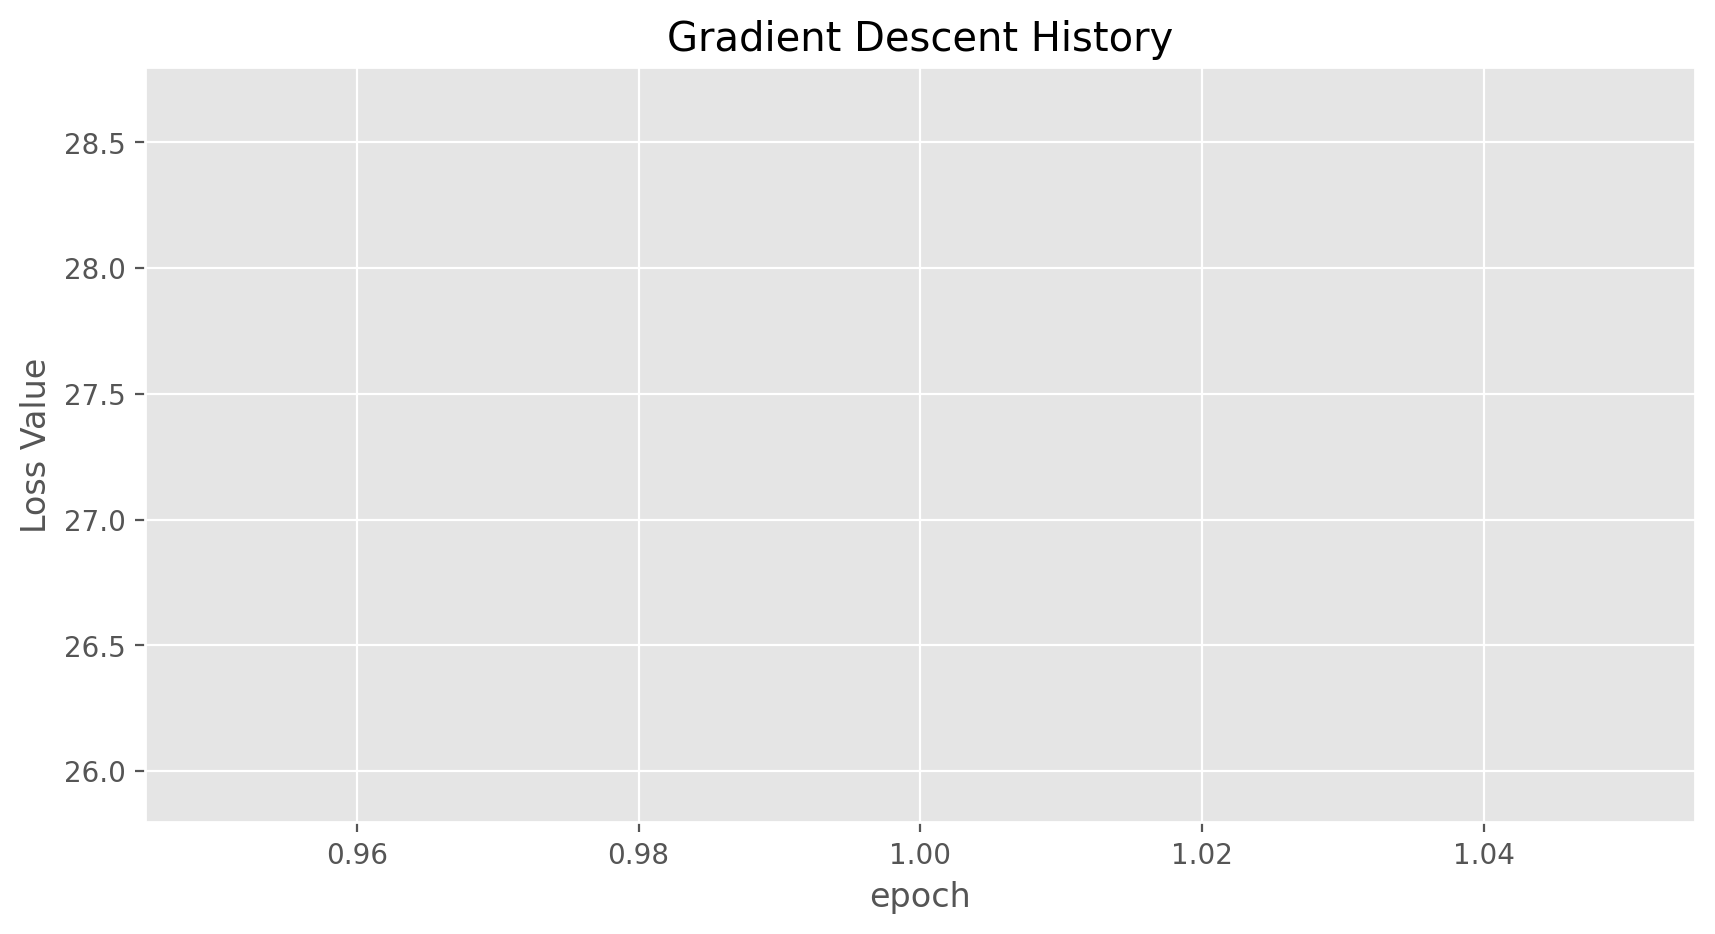

In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = plt.axes()
ax.plot(list(range(1, len(loss_history) + 1, 1)),loss_history )
ax.set(xlabel='epoch', ylabel='Loss Value',
       title='Gradient Descent History')
